# Setting up depedencies

I wan  to shortly compare the results of Grisou against Simgrid prediction.

In [3]:
%load_ext rpy2.ipython

In [7]:
%%R -w 18 -h 8 --units in
library(tidyverse)
library(viridis)

theme_set(theme_minimal(base_size = 18))

load_instance_grisou = function(path, noise) {
    instance = path
    data = read_table2(paste0(instance, "grisou-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "Router (eno1)", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "grisou-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Router (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
        bind_rows( read_table2(paste0(instance, "grisou-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Tcpkali", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "grisous-11.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "MPI (only one host)", timestamp = timestamp - min(timestamp)) ) %>%
    mutate(noise = noise)
}

/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/nix/store/bz5kg95lm41njiddm8sp12jgwds1mqhi-python3-3.7.3-env/lib/python3.7/site-packa

# Visualisation

First we print the bar plot of the different running times.
On can see, that none of the instances with 1 subdivisions, and blocking bcast suceed to finish before the timeout (of 45min).

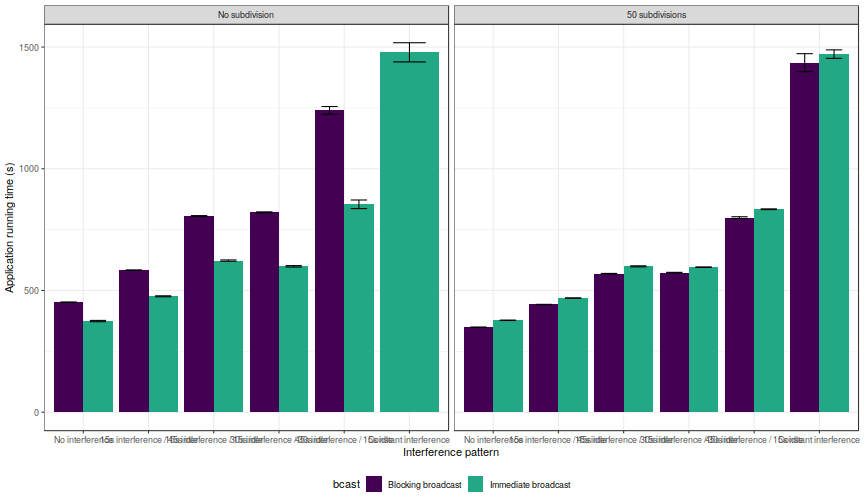

In [17]:
%%R -w 12 -h 7 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

ilevels = c("No interference",
            "15s interference / 45s idle", 
            "15s interference / 15s idle",  
            "30s interference / 30s idle",
            "45s interference / 15s idle", 
            "Constant interference")

theme_set(theme_minimal(base_size = 18))

data = read_csv("../experiments/g5k/data/grisou/12_july/grisou_all_instance.csv") %>% 
    mutate(interference = str_replace(interference, "no_kali", "No interference")) %>%
    mutate(interference = str_replace(interference, "noper", "Constant interference")) %>%
    mutate(interference = str_replace(interference, "per15sidle45sinter", "45s interference / 15s idle")) %>%
    mutate(interference = str_replace(interference, "per45sidle15inter", "15s interference / 45s idle")) %>%
    mutate(interference = str_replace(interference, "per45sidle15sinter", "15s interference / 45s idle")) %>%
    mutate(interference = str_replace(interference, "per15s", "15s interference / 15s idle")) %>%
    mutate(interference = str_replace(interference, "periods30s", "30s interference / 30s idle")) %>%
    mutate(nb_sub = str_replace(nb_sub, "1_subdivision", "No subdivision"), 
           nb_sub = str_replace(nb_sub, "50_subdivision", "50 subdivisions")) %>%
    mutate(nb_sub = factor(nb_sub, levels = c("No subdivision", "50 subdivisions"))) %>% 
    mutate(bcast = str_replace(bcast, "IBcast", "Immediate broadcast"),
           bcast = str_replace(bcast, "Bcast", "Blocking broadcast"))

stats <- data %>% group_by(interference, nb_sub, bcast) %>% 
    summarise( sd_time = sd(runtime), mean_runtime = mean(runtime), n = n())

stats %>% ggplot(aes(y = mean_runtime, x = factor(interference, levels = ilevels), fill = bcast)) +
    geom_bar(stat = "identity", position = position_dodge())+  
    xlab("Interference pattern") + ylab("Application running time (s)") +
    facet_grid(~nb_sub) + 
    geom_errorbar(aes(ymin = mean_runtime - sd_time, ymax = mean_runtime + sd_time), 
                  position = position_dodge(0.9), width = 0.5) +
    scale_fill_viridis_d(end = 0.6) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    theme_bw(base_size = ) +
    theme(legend.position = "bottom")
    


# A tibble: 23 x 8
# Groups:   bcast, nb_sub [4]
   bcast    nb_sub   interference    mean     sd  base inc_percentage key       
   <chr>    <fct>    <chr>          <dbl>  <dbl> <dbl>          <dbl> <chr>     
 1 Blockin… No subd… 15s interfere…  806.  1.79   452.           78.3 Blocking …
 2 Blockin… No subd… 15s interfere…  584.  0.562  452.           29.1 Blocking …
 3 Blockin… No subd… 30s interfere…  821.  1.81   452.           81.7 Blocking …
 4 Blockin… No subd… 45s interfere… 1240. 15.8    452.          174.  Blocking …
 5 Blockin… No subd… No interferen…  452.  0.461  452.            0   Blocking …
 6 Blockin… 50 subd… 15s interfere…  569.  0.845  349.           63.1 Blocking …
 7 Blockin… 50 subd… 15s interfere…  442.  0.575  349.           26.8 Blocking …
 8 Blockin… 50 subd… 30s interfere…  573.  1.11   349.           64.3 Blocking …
 9 Blockin… 50 subd… 45s interfere…  799.  3.58   349.          129.  Blocking …
10 Blockin… 50 subd… Constant inte… 1436. 36.9    349.      

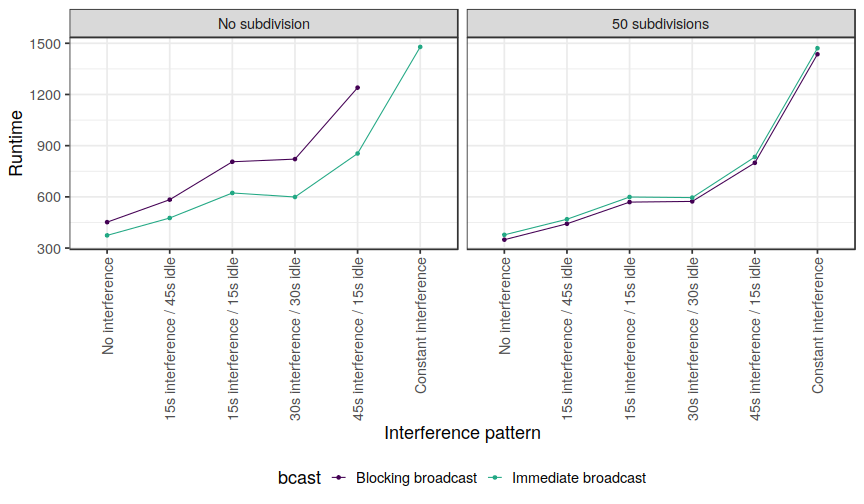

In [18]:
%%R -w 12 -h 7 --units in

print(inc_percentages)
inc_percentages %>% 
    ggplot(aes(y = mean, group = key, x = factor(interference, levels = ilevels), color = bcast)) +
    geom_point() +
    geom_line() +
    facet_grid(~nb_sub) +
    scale_color_viridis_d(end = 0.6) + 
    theme_bw(base_size = 18) +
    ylab("Runtime") + 
    xlab("Interference pattern") + 
    theme(legend.position = "bottom") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


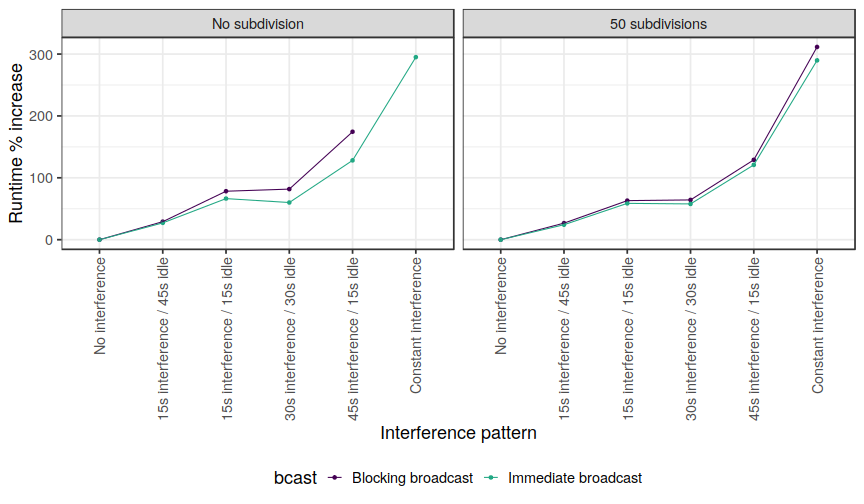

In [19]:
%%R -w 12 -h 7 --units in

# We compute the increase percentage of interference compared to the run without interference
# - Mean runtime for each config
# - Find the config with the lowest (mean) runtime (should be the no interference)
# - Attach this runtime to the others means and compute the increase percentage ((mean_runtime - base) / base) * 100 
sums = data %>% group_by(bcast, nb_sub, interference) %>%
  summarize(mean = mean(runtime), sd = sd(runtime))

find_base = sums %>% group_by(bcast, nb_sub) %>% summarise(base = min(mean))

inc_percentages = full_join(sums, find_base, by= c("nb_sub", "bcast")) %>% 
  mutate(inc_percentage = (mean - base ) / base * 100, key = paste(bcast, nb_sub)) # %>% filter(interference != "No interference")

inc_percentages %>% 
    ggplot(aes(y = inc_percentage, group = key, x = factor(interference, levels = ilevels), color = bcast)) +
    geom_point() +
    geom_line() +
    facet_grid(~nb_sub) +
    scale_color_viridis_d(end = 0.6) + 
    theme_bw(base_size = 18) +
    ylab("Runtime % increase") + 
    xlab("Interference pattern") + 
    theme(legend.position = "bottom") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# A tibble: 15 x 12
    slow  fast runtime src   interference bcast nb_sub  base inc_percentage
   <dbl> <dbl>   <dbl> <chr> <chr>        <chr> <chr>  <dbl>          <dbl>
 1    30    30    553. gris… 30s interfe… Adhoc Adhoc   349           58.6 
 2    45    15    792. gris… 45s interfe… Adhoc Adhoc   349          127.  
 3    15    45    428. gris… 15s interfe… Adhoc Adhoc   349           22.8 
 4    60     0   1436. gris… Constant in… Adhoc Adhoc   349          311.  
 5     0    60    349  gris… No interfer… Adhoc Adhoc   349            0   
 6    30    30    456. ptask 30s interfe… Adhoc Adhoc   312           46.1 
 7    45    15    612. ptask 45s interfe… Adhoc Adhoc   312           96.1 
 8    15    45    372. ptask 15s interfe… Adhoc Adhoc   312           19.2 
 9    60     0    935. ptask Constant in… Adhoc Adhoc   312          200.  
10     0    60    312  ptask No interfer… Adhoc Adhoc   312            0   
11    30    30    399. para… 30s interfe… Adhoc Adhoc   374.        

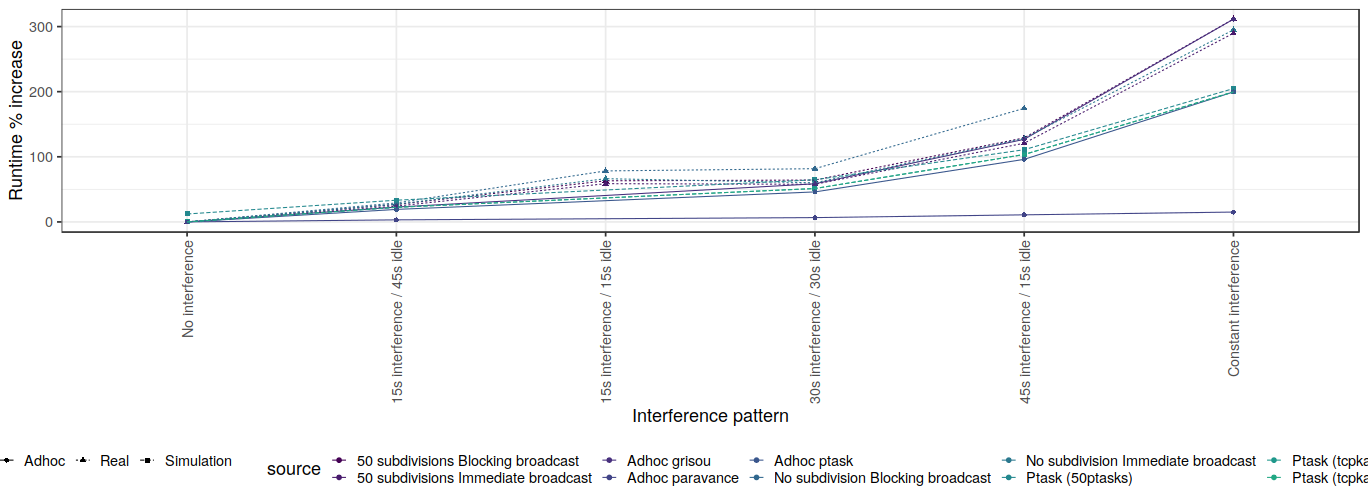

In [22]:
%%R  -w 19 -h 7 --units in

ptask = read_csv( "data/simulation_aggregated.csv") %>%
    mutate(bcast = "Simulation", nb_sub = "Simulation")

adhoc = read_csv( "data/adhoc.csv") %>%
    mutate(bcast = "Adhoc", nb_sub = "Adhoc") 
find_base = adhoc %>% group_by(src) %>% summarise(base = min(predicted_time))

adhoc_inc = full_join(adhoc, find_base, by= c("src")) %>% 
    mutate(inc_percentage = (predicted_time - base ) / base * 100, key = src, kind = "Adhoc") %>%
    mutate(source = paste("Adhoc", src)) %>%
    rename(runtime = "predicted_time")

print(adhoc_inc)

comp = inc_percentages %>% 
    mutate(source = paste(nb_sub, bcast), kind = "Real") %>% 
    rename(runtime = "mean") %>%
    bind_rows(ptask) %>%
    bind_rows(adhoc_inc)

write_csv(comp, "ya.csv")
comp %>% 
    ggplot(aes(y = inc_percentage, x = factor(interference, levels = ilevels), color = source, group = source, linetype = kind, shape = kind)) +
    geom_point(size = 2) +
    geom_line() +
    scale_color_viridis_d(end = 0.6) + 
    theme_bw(base_size = 18) +
    ylab("Runtime % increase") + 
    xlab("Interference pattern") + 
    theme(legend.position = "bottom") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggsave("img/Grisou_icrease_percent_comparison.pdf")


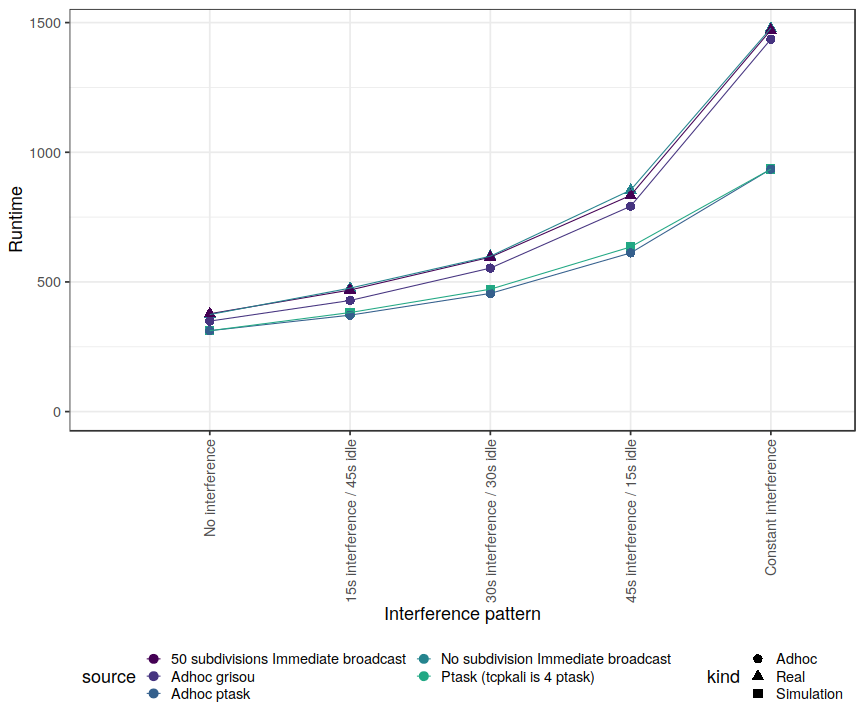

In [24]:
%%R  -w 12 -h 10 --units in

comp %>% filter(source != "Ptask (50ptasks)", source != "Ptask (tcpkali is s4u::Actor)", source != "Adhoc paravance") %>%
    filter(nb_sub != 1, bcast != "Blocking broadcast") %>%
    filter(interference != "15s interference / 15s idle") %>%
    ggplot(aes(y = runtime, x = factor(interference, levels = ilevels), color = source, group = source, shape = kind)) +
    geom_point(size =  4) +
    geom_line() +
    scale_color_viridis_d(end = 0.6) + 
    theme_bw(base_size = 18) +
    ylab("Runtime") + 
    xlab("Interference pattern") +
    theme(legend.position = "bottom") +
    expand_limits(x = 0, y = 0) +
    guides(color = guide_legend(ncol = 2), shape = guide_legend(ncol = 1)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggsave("img/Grisou_reality_ptask_runtime_comparison.pdf")
